In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "decoder" # encoder or decoder
task = "rte"
# task = "cb"
# task = "wic"

## Prompts

In [3]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,gpt_3_true_false_with_targets,{premise} Question: {hypothesis} True or False?,instructive,True,"▁True, ▁False","0, 1",False
2,gpt_3_cat_dog_with_targets,{premise} Question: {hypothesis} Cat or Dog?,instructive,True,"▁Cat, ▁Dog","0, 1",False
3,gpt_3_yes_no_without_targets,{premise} Question: {hypothesis}?,instructive,False,"▁Yes, ▁No","0, 1",False


## Comput CKA

In [4]:
if task == 'rte':
    use_pattern = [
        "gpt_3_yes_no_with_targets",
        "gpt_3_true_false_with_targets",
        "gpt_3_cat_dog_with_targets",
        "gpt_3_yes_no_without_targets",
    ]
elif task == 'cb':
    use_pattern = [
        "null_pattern",
        "null_pattern_reversed",
        "gpt_3_true_false_neither",
        "gpt_3_yes_no_maybe",
        "mnli_crowdsource",
        "always_sometimes_never",
        "based_on_previous_passage",
        "infer",
        "claim",
        "consider",
        "follow",
        "imply",
        "guaranteed",
        "guaranteed_possible",
        "justified",
        "must_be_true",
        "should_assume",
        "take_the_following",
    ]
elif task == 'wic':
    use_pattern = [
        "gpt_3",
        "gpt_3_yes_no",
        "affirmation",
        "grammar_homework",
        "polysemous",
        "question_context",
        "question_meaning",
        "question_meaning_yes_no",
        "same_sense",
        "similar_sense",
        "similar_sense_yes_no",
    ]

In [5]:
representations = {}

# For decoder representations we need to additionally specify the generated token
# We currently save representations for t=0 and t=1
for t in range(2):
    if t not in representations:
            representations[t] = {}

    # for layer in range(0, 1):
    # for layer in range(0, 5):
    for layer in range(0, 25):
    # for layer in range(24, 25):
        
        file_names, prompt_names = [], []

        layer_key = f"{module}-{layer}"
        if layer_key not in representations[t]:
            representations[t][layer_key] = {}
        
        for _, row in df.iterrows():
            if row['name'] in use_pattern:
                file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5"
                file_names.append(file_name)
                prompt_names.append(row['name'])
                if file_name not in representations[t][layer_key]:
                    # load hidden representations from hdf5 file
                    representations[t][layer_key][file_name] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
    
    

In [6]:
representations[0]["decoder-0"].keys()

dict_keys(['rte/bigscience-T0_3B/decoder/gpt_3_yes_no_with_targets/hidden_represenations_t0_layer0_avg.hdf5', 'rte/bigscience-T0_3B/decoder/gpt_3_true_false_with_targets/hidden_represenations_t0_layer0_avg.hdf5', 'rte/bigscience-T0_3B/decoder/gpt_3_cat_dog_with_targets/hidden_represenations_t0_layer0_avg.hdf5', 'rte/bigscience-T0_3B/decoder/gpt_3_yes_no_without_targets/hidden_represenations_t0_layer0_avg.hdf5'])

In [7]:
len(representations[0]["decoder-0"].keys())

4

In [8]:
# Compute pairwise CKA for every layer
np_cka = CKA()

cka_scores_layers = {}

for t in range(2):
    if t not in cka_scores_layers:
        cka_scores_layers[t] = {}

    for layer in list(representations[t].keys())[:]:
        cka_scores = []
        for pattern1 in representations[t][layer].keys():
            cka_scores_pattern1 = []
            for pattern2 in representations[t][layer].keys():
                cka_score = np_cka.linear_CKA(representations[t][layer][pattern1], representations[t][layer][pattern2])
                cka_scores_pattern1.append(cka_score)
            cka_scores.append(cka_scores_pattern1)
        cka_scores = np.asarray(cka_scores)
        cka_scores_layers[t][layer] = cka_scores
        # print(cka_scores.shape)


In [9]:
cka_scores_layers

{0: {'decoder-0': array([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
  'decoder-1': array([[1.        , 0.98096454, 0.98091108, 0.97556858],
         [0.98096454, 1.        , 0.97200254, 0.96303375],
         [0.98091108, 0.97200254, 1.        , 0.97300787],
         [0.97556858, 0.96303375, 0.97300787, 1.        ]]),
  'decoder-2': array([[1.        , 0.980842  , 0.97933758, 0.97569458],
         [0.980842  , 1.        , 0.97039782, 0.96306611],
         [0.97933758, 0.97039782, 1.        , 0.97246447],
         [0.97569458, 0.96306611, 0.97246447, 1.        ]]),
  'decoder-3': array([[1.        , 0.98820171, 0.98966849, 0.98328863],
         [0.98820171, 1.        , 0.98438601, 0.9754601 ],
         [0.98966849, 0.98438601, 1.        , 0.98481268],
         [0.98328863, 0.9754601 , 0.98481268, 1.        ]]),
  'decoder-4': array([[1.        , 0.9889975 , 0.99073294, 0.98416538],
         [0.9889975 , 1.        , 0.98576534, 0.9

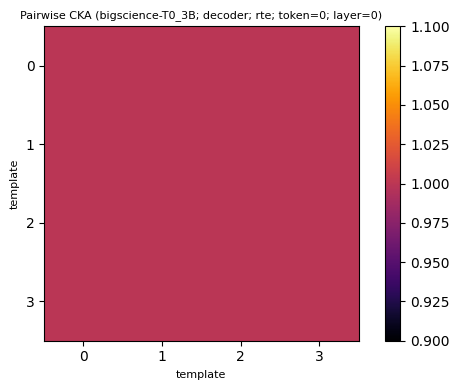

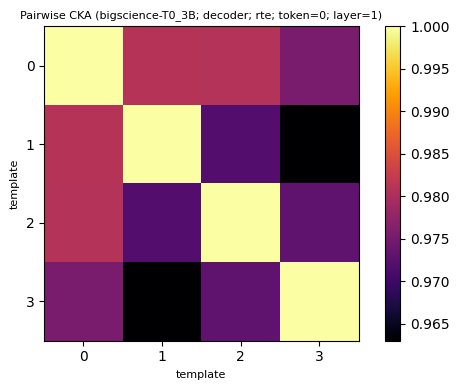

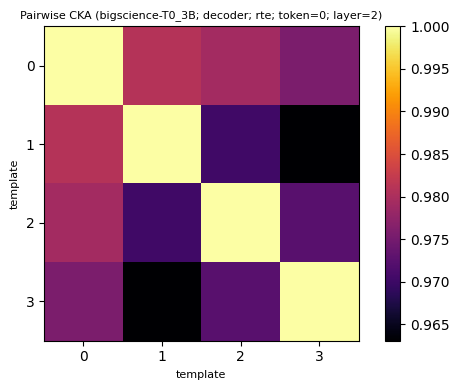

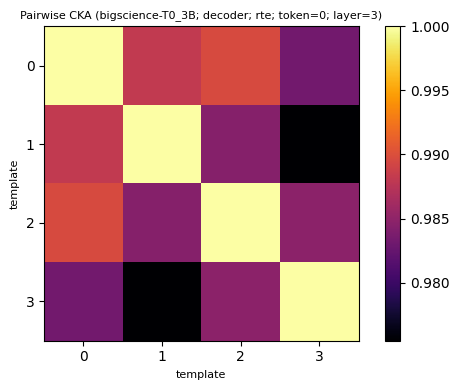

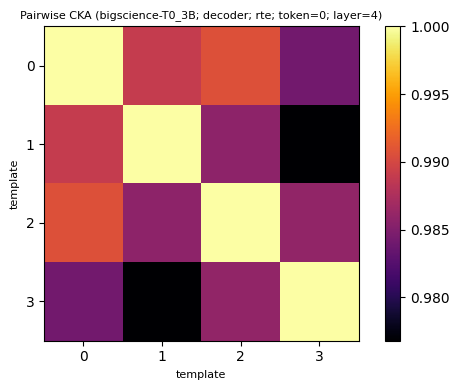

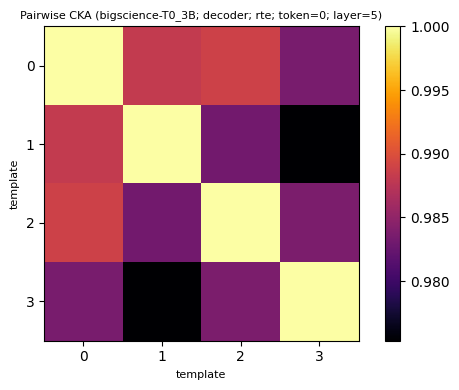

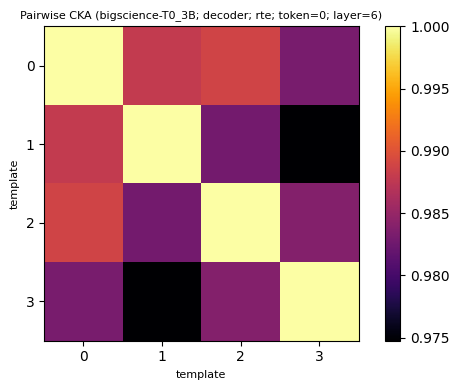

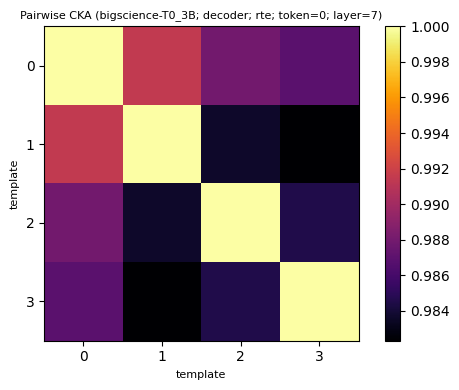

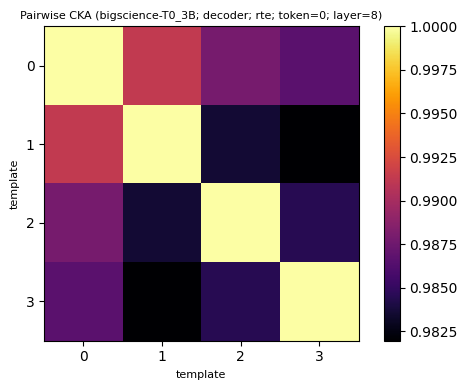

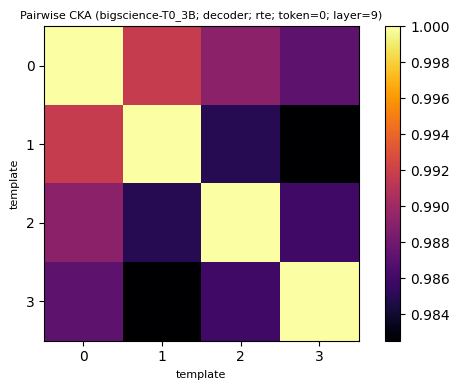

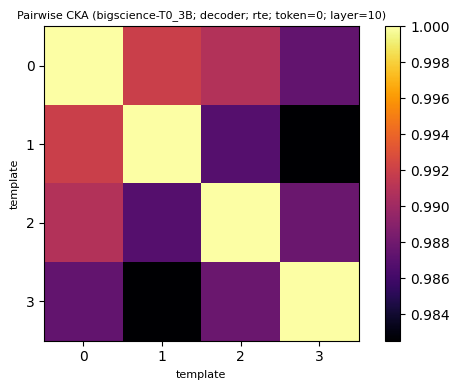

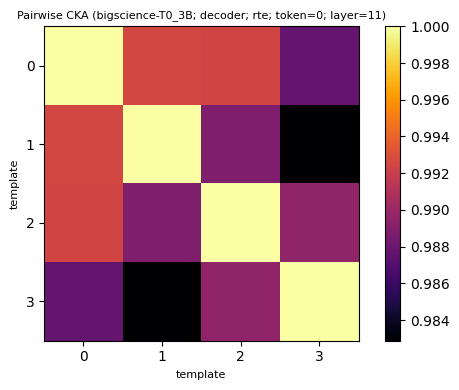

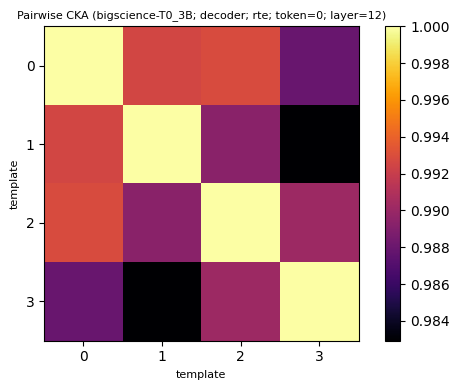

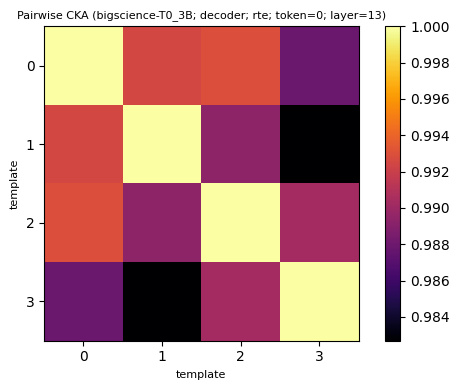

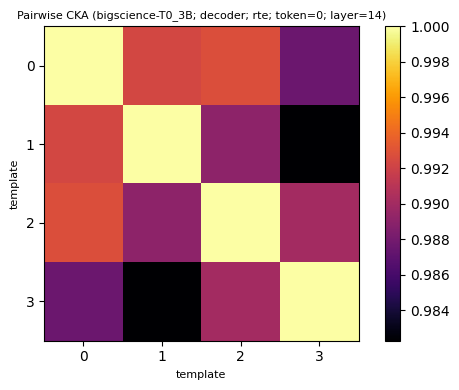

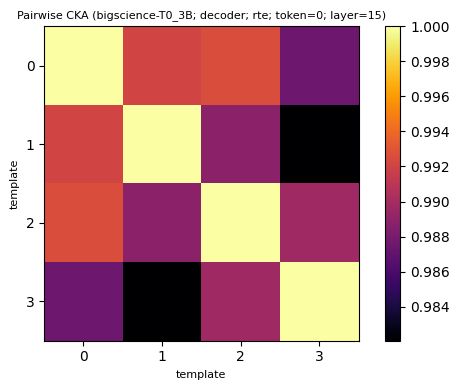

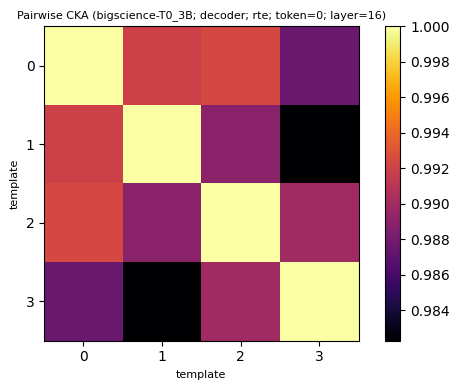

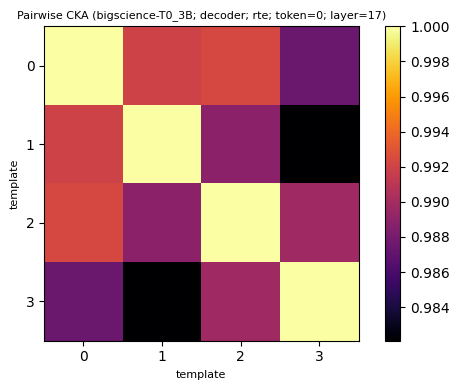

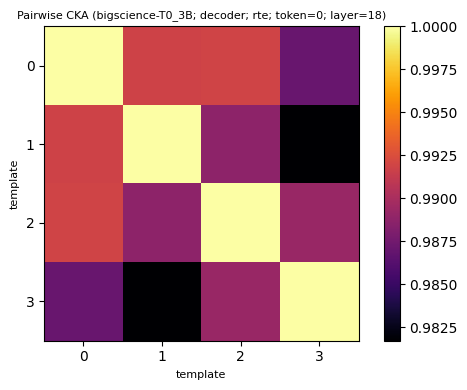

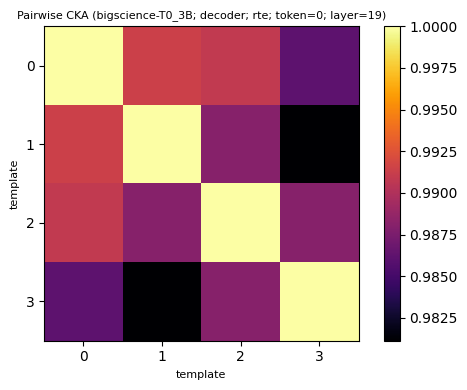

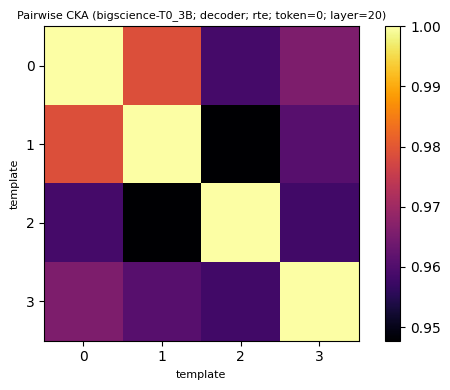

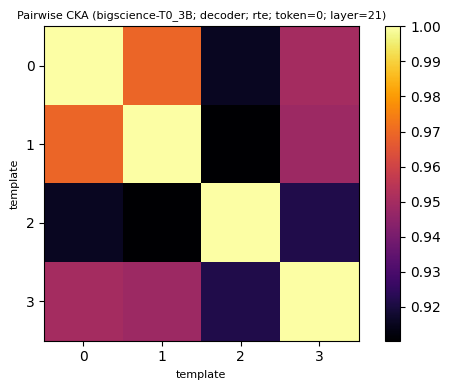

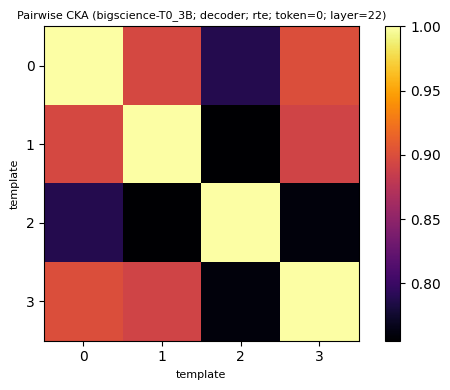

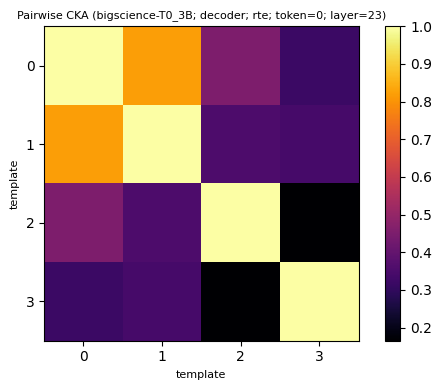

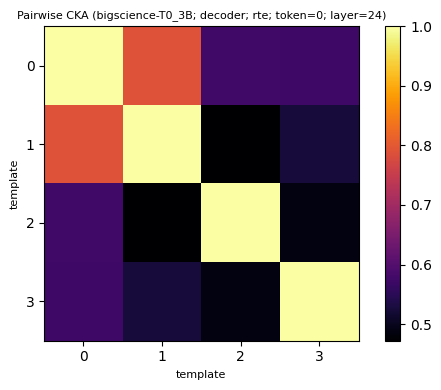

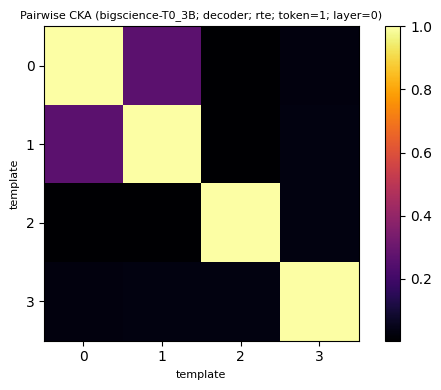

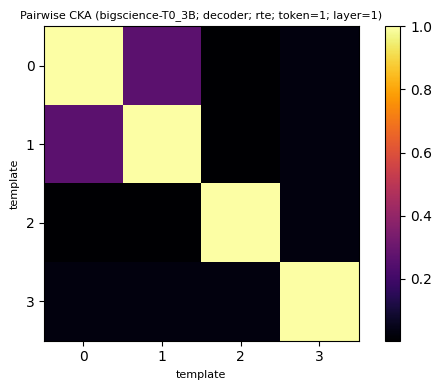

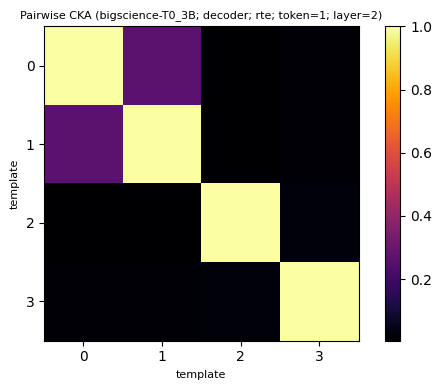

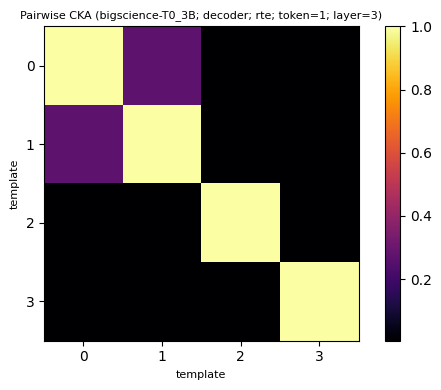

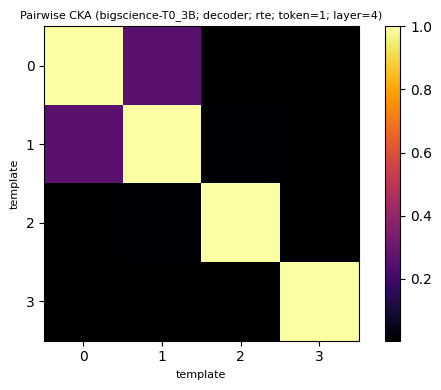

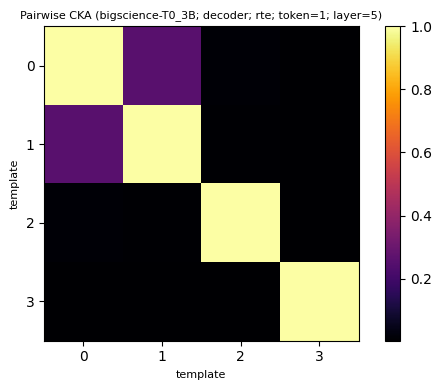

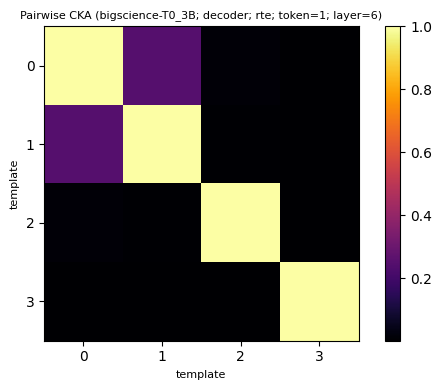

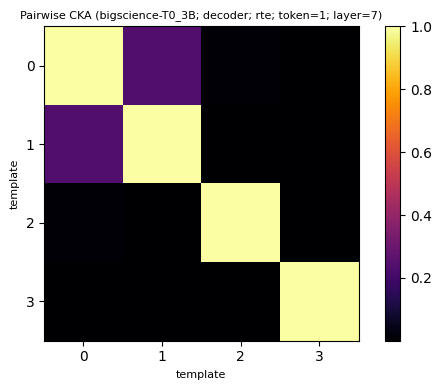

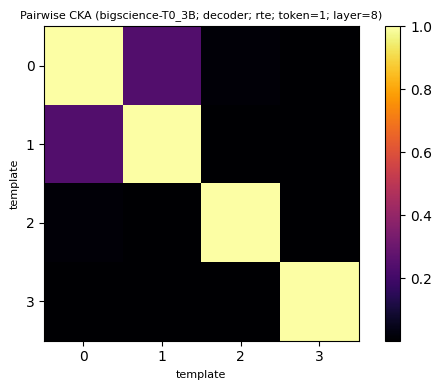

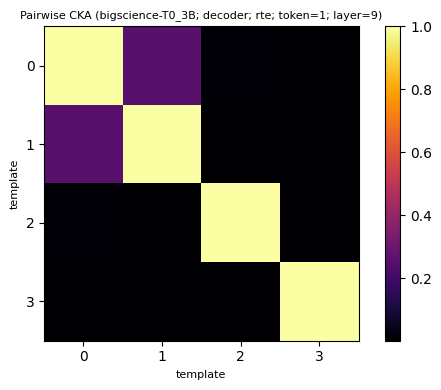

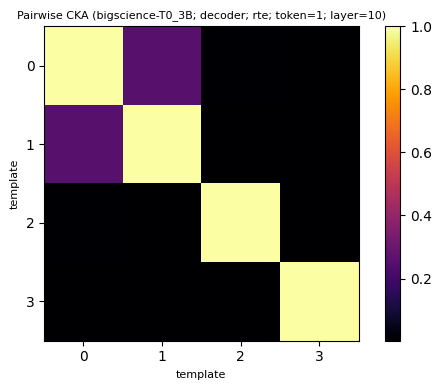

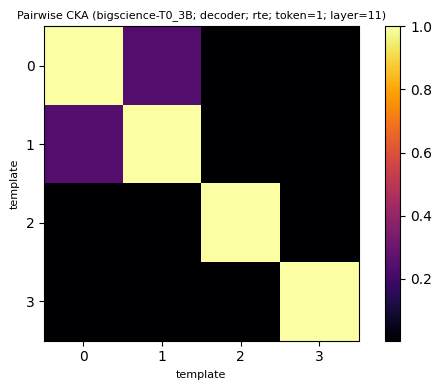

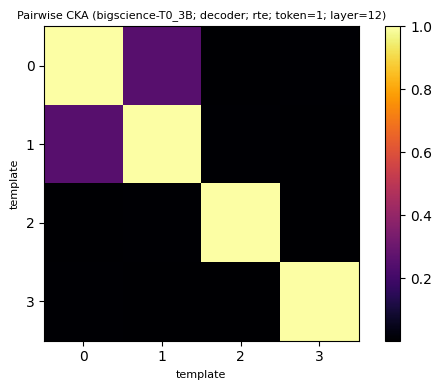

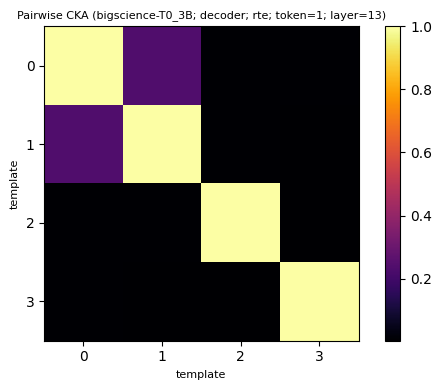

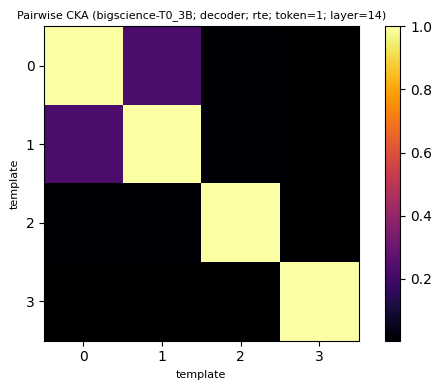

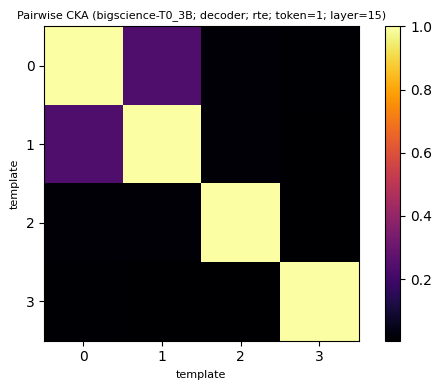

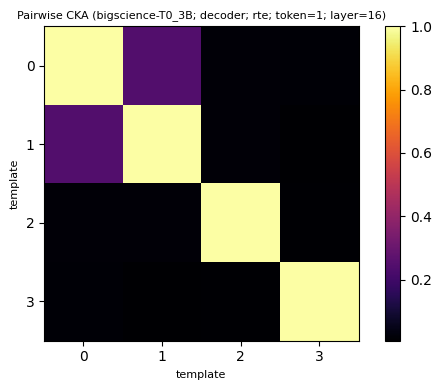

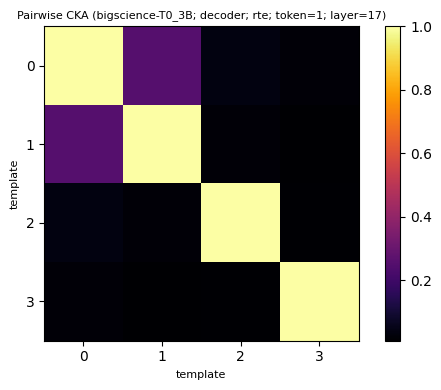

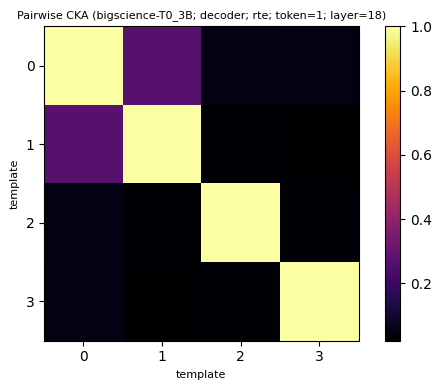

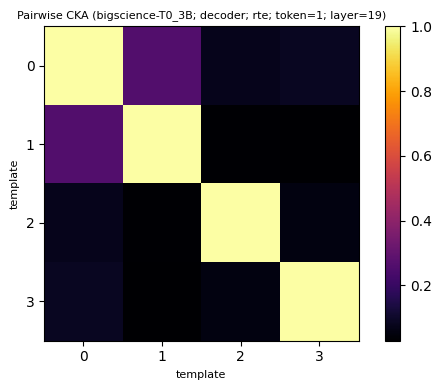

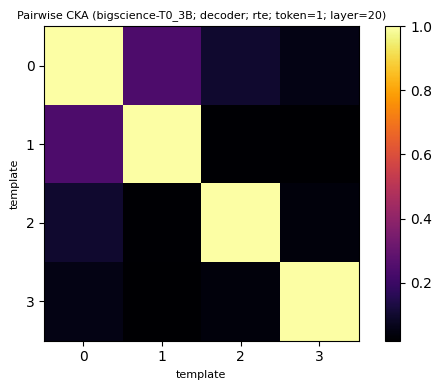

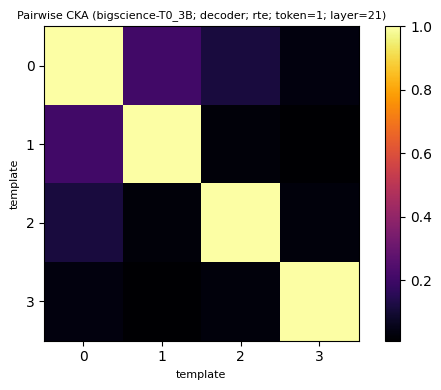

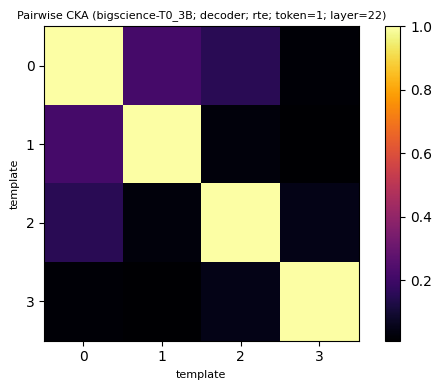

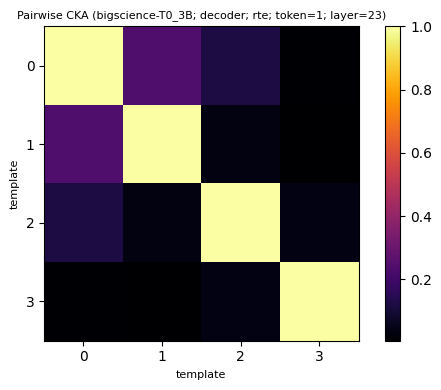

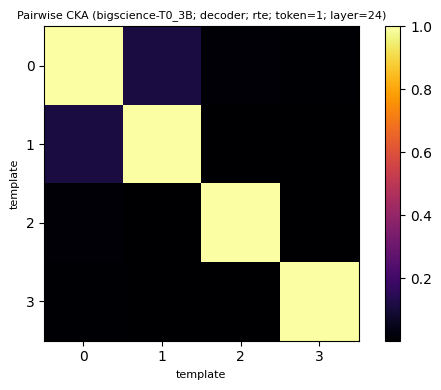

In [10]:
for token_key in cka_scores_layers.keys():
    for layer_key in cka_scores_layers[token_key].keys():
        values = cka_scores_layers[token_key][layer_key]
        layer = layer_key.split('-')[-1]

        fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=100)

        im = axes.imshow(values, cmap='inferno', vmax=1.0)
        # Create colorbar
        cbar = axes.figure.colorbar(im, ax=axes)
        cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("template", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("template", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; token={token_key}; layer={layer})", fontsize=8)

        plt.tight_layout()
        plt.show()
        plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


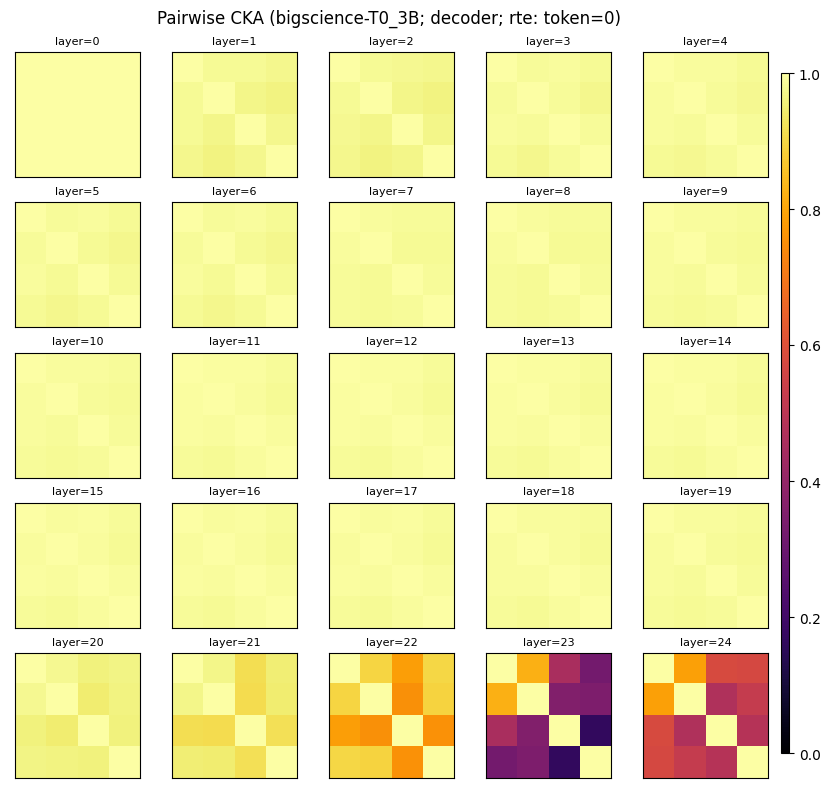

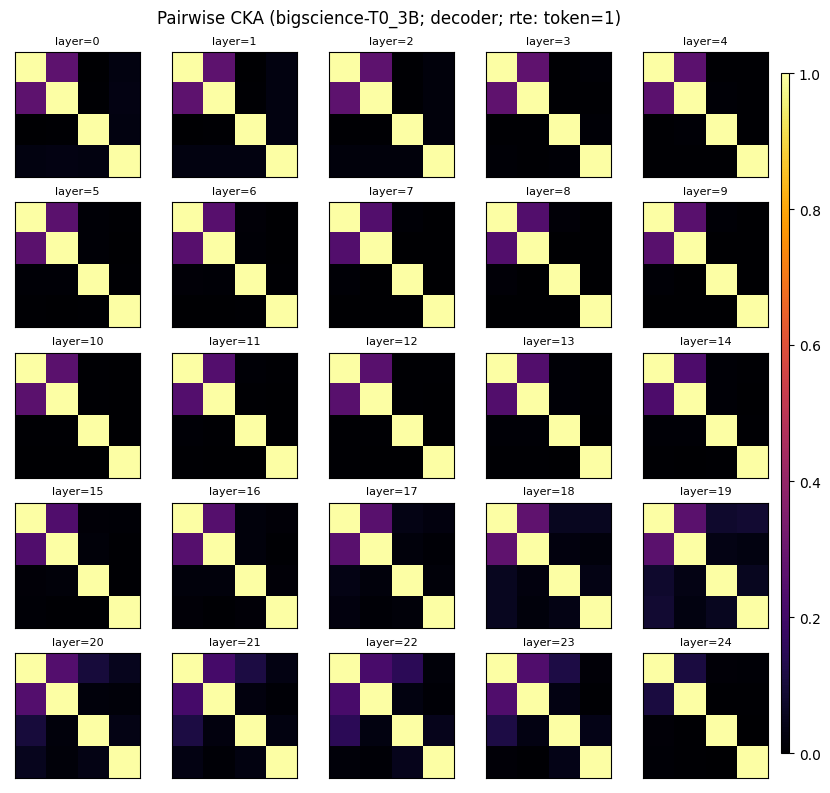

In [11]:
for t in range(2):
    plt.figure(figsize=(8, 8), dpi=100)

    for l, layer_key in enumerate(cka_scores_layers[t].keys()):
        values = cka_scores_layers[t][layer_key]
        layer = layer_key.split('-')[-1]

        plt.subplot(5, 5, l+1)
        axes = plt.gca()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        # cbar = axes.figure.colorbar(im, ax=axes)
        # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("template", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("template", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
        axes.set_title(f"layer={layer}", fontsize=8)

    # add colorbar
    fig = plt.gcf()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.05, 0.01, 0.85])
    fig.colorbar(im, cax=cbar_ax)

    plt.suptitle(f"Pairwise CKA ({model}; {module}; {task}: token={t})")
    plt.tight_layout()
    plt.show()
    plt.close();

In [13]:
df

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,gpt_3_true_false_with_targets,{premise} Question: {hypothesis} True or False?,instructive,True,"▁True, ▁False","0, 1",False
2,gpt_3_cat_dog_with_targets,{premise} Question: {hypothesis} Cat or Dog?,instructive,True,"▁Cat, ▁Dog","0, 1",False
3,gpt_3_yes_no_without_targets,{premise} Question: {hypothesis}?,instructive,False,"▁Yes, ▁No","0, 1",False


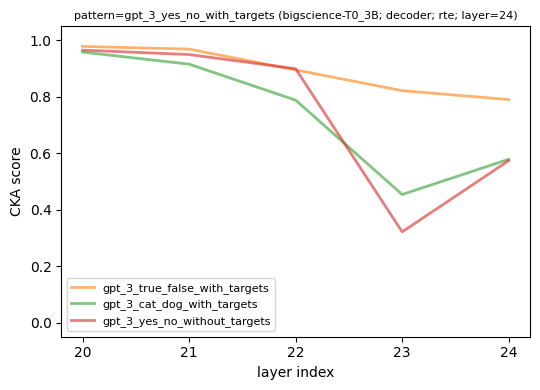

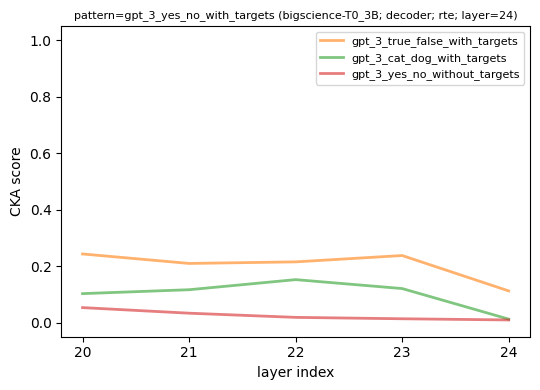

In [14]:
pattern1 = 0

for t in range(2):

    fig, axes = plt.subplots(1, 1, figsize=(5.5, 4), dpi=100)

    cmap = matplotlib.cm.get_cmap('tab10')
    # cmap = matplotlib.cm.get_cmap('tab20')
    colors = cmap.colors

    for idx, pattern2 in enumerate(range(len(df))[:]):
        if pattern2 == pattern1:
            continue
        pattern_sim = []

        layers = []
        for layer in list(cka_scores_layers[t].keys())[-5:]:
            layers.append(layer.split('-')[-1])
            cka_score = cka_scores_layers[t][layer][pattern1, pattern2]
            pattern_sim.append(cka_score)
        
        axes.plot(pattern_sim, linewidth=2.0, alpha=0.6, color=colors[idx], label=f"{df.iloc[pattern2]['name']}")

    axes.set_ylim(-0.05, 1.05)
    axes.set_xticks(np.arange(len(pattern_sim)))
    axes.set_xticklabels(layers)
    axes.set_xlabel("layer index")
    axes.set_ylabel("CKA score")

    axes.set_title(f"pattern={df.iloc[pattern1]['name']} ({model}; {module}; {task}; layer={layer.split('-')[-1]})", fontsize=8)

    axes.legend(loc='best', fontsize=8)
    # Put a legend to the right of the current axis
    # axes.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

    plt.tight_layout();